In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import math
from copy import deepcopy
import plotly.offline as offline
import plotly.graph_objs as go
import plotly.offline as py

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [2]:
Xtrain_path = "./Xtrain.csv"
Ytrain_path = "./Ytrain.csv"

In [3]:
Xtrain = pd.read_csv(Xtrain_path)
Ytrain = pd.read_csv(Ytrain_path)
train_data = pd.merge(Xtrain,Ytrain)

In [4]:
train_data.head(5)

Id                            Name            City State    Zip  \
0   0                 NPE Realty, LLC  Pembroke Pines    FL  33027   
1   1        KEVCO  CONSTRUCTION, LLC           SANDY    UT  84094   
2   2            EAST L A SHOE REPAIR     LOS ANGELES    CA  90022   
3   3           RUSSLER, DANIEL C, MD            LODI    WI  53555   
4   4  AFFORDABLE FAMILY DENISTRY LLC         LEBANON    MO  65536   

                            Bank BankState   NAICS ApprovalDate ApprovalFY  \
0  TD BANK, NATIONAL ASSOCIATION        DE  334516    16-Apr-10       2010   
1      ZIONS FIRST NATIONAL BANK        UT  236115    30-Jan-10       2010   
2     BANK OF AMERICA NATL ASSOC        NC  811430    29-Jul-02       2002   
3     ASSOCIATED BANK NATL ASSOC        WI       0    10-Jun-94       1994   
4                  COMMERCE BANK        MO  621210     6-Feb-06       2006   

   ...  FranchiseCode  UrbanRural  RevLineCr  LowDoc  DisbursementDate  \
0  ...              0           1          N       N          1-May-10   
1  ...              0           1          N       N          1-Feb-10   
2  ...              1           1          Y       N         31-Aug-02   
3  ...              1           0          N       N         31-Jul-94   
4  ...              1           1          T       N         31-Mar-06   

   DisbursementGross  BalanceGross          GrAppv        SBA_Appv ChargeOff  
0     $2,000,000.00         $0.00   $2,000,000.00   $1,500,000.00          0  
1        $17,000.00         $0.00      $17,000.00      $17,000.00          1  
2        $17,000.00         $0.00      $17,000.00       $8,500.00          0  
3       $137,000.00         $0.00     $137,000.00     $123,300.00          0  
4        $46,665.00         $0.00      $25,000.00      $12,500.00          0  

[5 rows x 25 columns]

In [5]:
train_data.columns

Index(['Id', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS',
       'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'GrAppv',
       'SBA_Appv', 'ChargeOff'],
      dtype='object')

In [6]:
NewExists = train_data[['Id','NewExist']].copy()
CreateJobs = train_data[['Id','CreateJob']].copy()
RetainedJobs = train_data[['Id','RetainedJob']].copy()
FranchiseCodes = train_data[['Id','FranchiseCode']].copy()
UrbanRurals = train_data[['Id','UrbanRural']].copy()
RevLineCrs = train_data[['Id','RevLineCr']].copy()
LowDocs = train_data[['Id','LowDoc']].copy()
DisbursementDates = train_data[['Id','DisbursementDate']].copy()
DisbursementGrosss = train_data[['Id','DisbursementGross']].copy()
BalanceGrosss = train_data[['Id','BalanceGross']].copy()
GrAppvs = train_data[['Id','GrAppv']].copy()
SBA_Appvs = train_data[['Id','SBA_Appv']].copy()
ChargeOffs = train_data[['Id','ChargeOff']].copy()

In [7]:
def extractRows(df,appear_times,columns,larger=True):
    # given the output that 
    #     for the given columns, the num of certain pair appears more/less than "appear_times". Delete the others.
    # e.g. a = extractRows(name_out,5,columns = ['Name','ChargeOff'],larger=True)   
    #            will select the ['Name','ChargeOff'] pair that appears more than 5 times.
    a = df[columns].value_counts()
    if larger:
        a_t = a[a>appear_times].index
    else:
        a_t = a[a<appear_times].index
    a_t = pd.DataFrame(a_t,columns=None)[0]
    name_list = []
    
    for item in a_t:
        name_list.append([item[i] for i in range(len(item))])
    df_cp = df.copy()
    drop_list = []
    for idx,item in enumerate(df_cp[columns].values):
        if list(item) in name_list:
            continue
        else:
            drop_list.append(idx)
    df_cp.drop(drop_list,inplace=True)
    
    return df_cp

In [8]:
def preprocess_str_extend(Name_df,familiar_names,column):
    length = len(familiar_names)
    def foo(x):
        for idx,familiar_name in enumerate(familiar_names): # trick reverse order to speed up
            if x in familiar_name:
                return length-idx-1
        return 0
    Name_df[column] = Name_df[column].map(lambda x: foo(x))
    return Name_df

In [270]:
def find_missing_zero(df_column):
    # find the missing/zero value
    nan_values_row_idx = []
    zero_values_row_idx = []
    for i,item in enumerate(df_column):
        if not item:
            zero_values_row_idx.append(i)
        elif isinstance(item,str):
            continue
        elif math.isnan(item):
            nan_values_row_idx.append(i)
    nan_values_row_idx = list(set(nan_values_row_idx))
    zero_values_row_idx = list(set(zero_values_row_idx))
    # BankStates = BankStates.drop(index=nan_values_row_idx)
    print(nan_values_row_idx)
    print(zero_values_row_idx)
    return nan_values_row_idx,zero_values_row_idx

In [10]:
def plotPassRate(out_df,num_values,show_nodes=200):
    y1 = np.ones(num_values)
    y2 = np.ones(num_values)
    for item in out_df.values:
        y1[item[1]]+=item[2]
        y2[item[1]]+=1
    passRate = []
    for i,j in zip(y1,y2):
        passRate.append(i/j)
    # PassRate of different term
    x = range(0,num_values) # I do norm, so it will larger than 1
    from scipy.interpolate import make_interp_spline
    xnew = np.linspace(min(x),max(x),show_nodes) #300 represents number of points to make between T.min and T.max
    power_smooth = make_interp_spline(x,passRate)(xnew)
    plt.plot(xnew,power_smooth)
    plt.show()
#     # number of different term
#     plt.plot(x,y2)
#     plt.show()
    return y1,y2

In [15]:
def blacklistModify(input_data,input_out,thresold,column_name,npy_name,larger=True):
    a_t = extractRows(input_out,thresold,columns = [column_name],larger=larger)
    blanklist = list(set(list(a_t[column_name])))
    np.save(npy_name,np.array(blanklist))
    def foo(x):
        if x in blanklist:
            return 0
        else:
            return 1
    input_data[column_name] = input_data[column_name].map(lambda x: foo(x))

def whitelistModify(input_data,input_out,thresold,column_name,npy_name,larger=True):
    a_t = extractRows(input_out,thresold,columns = [column_name],larger=larger)
    whitelist = list(set(list(a_t[column_name])))
    np.save(npy_name,np.array(whitelist))
    def foo(x):
        if x in whitelist:
            return 1
        else:
            return 0
    input_data[column_name] = input_data[column_name].map(lambda x: foo(x))

# NewExist

In [16]:
NewExist_out = pd.merge(NewExists,ChargeOffs)

In [19]:
a = NewExist_out['NewExist'].value_counts()
a

1.0    35636
2.0    14328
0.0       29
Name: NewExist, dtype: int64

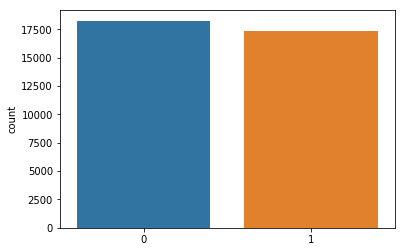

In [26]:
a_t = extractRows(NewExist_out,20000,columns = ['NewExist'],larger=True)
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

> Conclusion: quite balanced. Do nothing.Change to int.

In [28]:
nan_l,zero_l = find_missing_zero(NewExists['NewExist'])

[44391, 19087, 2863, 10225, 22525, 15093, 1469]
[10628, 519, 15113, 5520, 25500, 34717, 16420, 42664, 1961, 40876, 24881, 3382, 9406, 10705, 29269, 216, 3801, 42589, 3680, 13792, 37349, 11622, 27753, 4972, 8300, 13550, 30956, 8945, 47221]


> Process: According to the dataset_info. it only have 1 and 2. there is nan and zero value(a very small percent). I simply set them as new bussniess. And also, we label all new bussness using 0.

In [29]:

def foo(x):
    if x==1.0:
        return 1
    else:
        return 0
NewExists['NewExist'] = NewExists['NewExist'].map(lambda x: foo(x))

In [31]:
NewExists['NewExist'].value_counts()

1    35636
0    14364
Name: NewExist, dtype: int64

# CreateJob

In [82]:
find_missing_zero(CreateJobs['CreateJob']) # no nan

[]
[3, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 68, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90, 91, 92, 93, 94, 95, 97, 99, 100, 102, 103, 104, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 129, 132, 134, 135, 136, 139, 140, 141, 144, 146, 147, 148, 150, 151, 152, 155, 156, 159, 160, 161, 164, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 192, 194, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 211, 213, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 233, 239, 242, 243, 244, 245, 247, 248, 249, 250, 257, 258, 259, 260, 261, 264, 265, 269, 271, 272, 274, 275, 277, 278, 279, 280, 282, 283, 284, 285, 287, 290, 291, 292, 293, 294, 295, 297, 298, 299, 301, 302, 303, 304, 307, 308, 30

([],
 [3,
  7,
  8,
  10,
  12,
  14,
  15,
  16,
  17,
  18,
  19,
  21,
  22,
  24,
  25,
  27,
  28,
  29,
  30,
  31,
  32,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  58,
  59,
  61,
  62,
  63,
  64,
  68,
  70,
  71,
  73,
  74,
  75,
  76,
  78,
  79,
  80,
  81,
  82,
  84,
  85,
  86,
  88,
  90,
  91,
  92,
  93,
  94,
  95,
  97,
  99,
  100,
  102,
  103,
  104,
  107,
  108,
  109,
  110,
  111,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  122,
  123,
  124,
  125,
  126,
  127,
  129,
  132,
  134,
  135,
  136,
  139,
  140,
  141,
  144,
  146,
  147,
  148,
  150,
  151,
  152,
  155,
  156,
  159,
  160,
  161,
  164,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  192,
  194,
  196,
  197,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  209,
  211,


In [32]:
CreateJob_out = pd.merge(CreateJobs,ChargeOffs)

In [64]:
a = CreateJobs['CreateJob'].value_counts()
print(a[a>100])
max(CreateJobs['CreateJob'])

0     33805
1      4396
2      3811
3      1834
4      1230
5      1026
10      622
6       614
8       343
7       321
15      245
20      225
12      194
9       180
Name: CreateJob, dtype: int64


8800

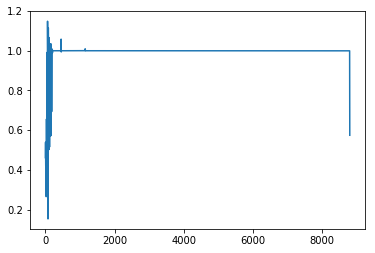

In [42]:
x = range(0,8801)
y1,y2 = plotPassRate(CreateJob_out,8801,show_nodes=2000)

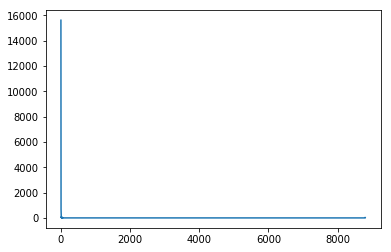

In [43]:
plt.plot(x,y1)
plt.show()

In [45]:
sum(y1[:440])/sum(y2[:440])

0.5012107979356888

In [46]:
sum(y1[440:])/sum(y2[440:])

0.9972687329295808

In [74]:
np.sum(y2[30:])-8770

448.0

In [81]:
for i in range(0,100):
    print(y1[i]/y2[i])
print()
print(sum(y2[81:])-len(y2[81:]))
print(sum(y1[81:]-len(y1[81:]))/sum(y2[81:]-len(y2[81:])))

print(sum(y2[11:80]))
print(sum(y1[11:80])/sum(y2[11:80]))

print(sum(y2[0:11]))
print(sum(y1[0:11])/sum(y2[0:11]))

0.46172277110572085
0.6770525358198772
0.6327387198321092
0.5923705722070844
0.5475223395613322
0.5335929892891919
0.47479674796747967
0.3447204968944099
0.4418604651162791
0.4198895027624309
0.4478330658105939
0.3
0.441025641025641
0.42424242424242425
0.4583333333333333
0.3861788617886179
0.2835820895522388
0.30612244897959184
0.31746031746031744
0.4
0.3805309734513274
0.2222222222222222
0.2641509433962264
0.3333333333333333
0.2692307692307692
0.33
0.35294117647058826
0.18181818181818182
0.3333333333333333
0.2727272727272727
0.2804878048780488
0.6666666666666666
0.2
0.5
0.35714285714285715
0.30952380952380953
0.42857142857142855
0.375
0.4444444444444444
0.6666666666666666
0.3235294117647059
1.0
0.2
0.5
1.0
0.18181818181818182
0.6666666666666666
0.75
0.25
0.5
0.4222222222222222
1.0
0.6666666666666666
1.0
1.0
0.7142857142857143
1.0
0.5
1.0
0.5
0.1111111111111111
1.0
1.0
0.5
1.0
0.5
1.0
0.5
0.5
1.0
0.3333333333333333
0.5
1.0
0.5
0.5
0.18181818181818182
1.0
0.5
1.0
1.0
0.6666666666666666


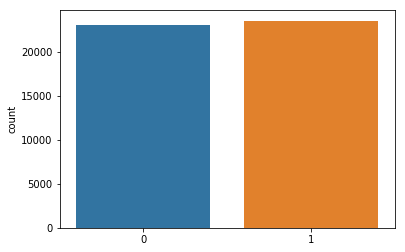

In [80]:
a_t = extractRows(CreateJob_out,620,columns = ['CreateJob'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

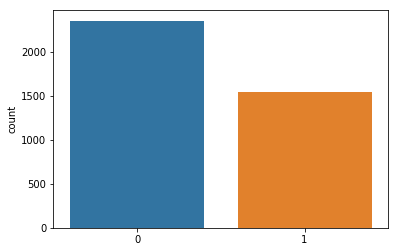

In [79]:
a_t = extractRows(CreateJob_out,1000,columns = ['CreateJob'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

> Conclusion: if it creates a lot of jobs(>80), ChargeOff tend to be 1. For very low job create(<10), no bias. For 10-100, tend to be 0.

> Process: split it to bins 0-10,10-80,80-, not very sure.

In [83]:
def foo(x):
    if x>80:
        return 2
    elif x>10:
        return 1
    else:
        return 0
CreateJobs['CreateJob'] = CreateJobs['CreateJob'].map(lambda x: foo(x))

In [84]:
CreateJobs['CreateJob'].value_counts()

0    48182
1     1714
2      104
Name: CreateJob, dtype: int64

# RetainJob

In [86]:
find_missing_zero(RetainedJobs['RetainedJob']) #no nan

[]
[0, 32768, 32769, 3, 32770, 32773, 32775, 32777, 12, 32782, 15, 16, 32783, 18, 32785, 32790, 24, 25, 32794, 32795, 28, 29, 32798, 31, 32, 32801, 32802, 35, 36, 32804, 32805, 41, 32809, 32810, 32812, 45, 46, 47, 32818, 52, 32822, 56, 59, 61, 62, 32829, 32830, 32836, 69, 70, 71, 72, 32839, 32840, 75, 32844, 78, 79, 80, 81, 32847, 84, 85, 87, 88, 90, 32858, 93, 94, 95, 32861, 32863, 32865, 99, 32866, 101, 102, 32871, 32873, 110, 111, 32879, 32880, 114, 115, 32883, 117, 118, 32886, 32887, 32888, 32891, 124, 32892, 127, 32896, 129, 32897, 32898, 132, 32901, 134, 135, 136, 32904, 32906, 139, 140, 32907, 32908, 143, 32909, 32913, 147, 148, 32916, 150, 32917, 152, 32918, 32919, 32922, 32925, 159, 32927, 161, 32928, 163, 32929, 32930, 32931, 167, 32936, 171, 172, 173, 32940, 175, 32941, 177, 32943, 179, 32944, 181, 32947, 183, 32948, 185, 32950, 187, 188, 189, 32952, 32954, 193, 194, 32962, 32964, 32966, 32967, 200, 32969, 202, 203, 204, 32970, 32971, 207, 208, 32973, 32975, 32977, 32980, 32

([],
 [0,
  32768,
  32769,
  3,
  32770,
  32773,
  32775,
  32777,
  12,
  32782,
  15,
  16,
  32783,
  18,
  32785,
  32790,
  24,
  25,
  32794,
  32795,
  28,
  29,
  32798,
  31,
  32,
  32801,
  32802,
  35,
  36,
  32804,
  32805,
  41,
  32809,
  32810,
  32812,
  45,
  46,
  47,
  32818,
  52,
  32822,
  56,
  59,
  61,
  62,
  32829,
  32830,
  32836,
  69,
  70,
  71,
  72,
  32839,
  32840,
  75,
  32844,
  78,
  79,
  80,
  81,
  32847,
  84,
  85,
  87,
  88,
  90,
  32858,
  93,
  94,
  95,
  32861,
  32863,
  32865,
  99,
  32866,
  101,
  102,
  32871,
  32873,
  110,
  111,
  32879,
  32880,
  114,
  115,
  32883,
  117,
  118,
  32886,
  32887,
  32888,
  32891,
  124,
  32892,
  127,
  32896,
  129,
  32897,
  32898,
  132,
  32901,
  134,
  135,
  136,
  32904,
  32906,
  139,
  140,
  32907,
  32908,
  143,
  32909,
  32913,
  147,
  148,
  32916,
  150,
  32917,
  152,
  32918,
  32919,
  32922,
  32925,
  159,
  32927,
  161,
  32928,
  163,
  32929,
  32930,


In [94]:
a = RetainedJobs['RetainedJob'].value_counts()
print(a[a>100])
max(RetainedJobs['RetainedJob'])

0     20247
1      6400
2      5145
3      3452
4      2664
5      2234
6      1544
7      1075
8       980
10      950
12      577
9       543
15      465
20      364
11      343
14      266
13      231
25      198
16      186
18      176
30      171
17      147
22      109
35      102
Name: RetainedJob, dtype: int64


8800

In [88]:
RetainedJobs_out = pd.merge(RetainedJobs,ChargeOffs)

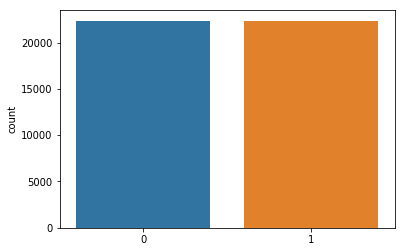

In [90]:
a_t = extractRows(RetainedJobs_out,900,columns = ['RetainedJob'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

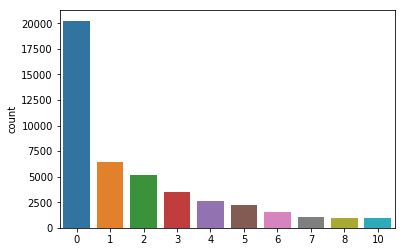

In [91]:
outcomes = a_t['RetainedJob'].values
sb.countplot(outcomes)

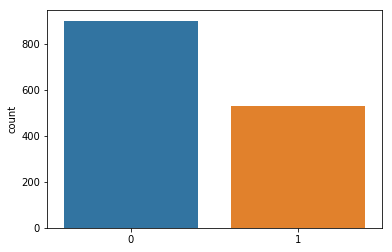

In [93]:
a_t = extractRows(RetainedJobs_out,100,columns = ['RetainedJob'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

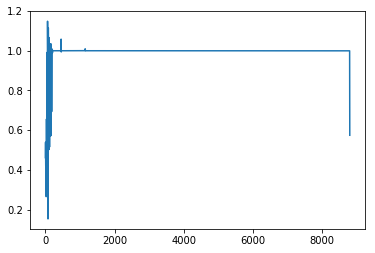

In [95]:
x = range(0,8801)
y1,y2 = plotPassRate(CreateJob_out,8801,show_nodes=2000)

> Conclusion: This feature is extremely similiar to the above one. In order to let the model automatically extract the feature. Here I choose to normalize the input. 

> Process: What I do is, let number>80 equals 80 and then /80

In [104]:
RetainedJobs = train_data[['Id','RetainedJob']].copy()

In [105]:
def foo(x):
    if x>=80:
        return 1.0
    else:
        return x/80
RetainedJobs['RetainedJob'] = RetainedJobs['RetainedJob'].map(lambda x: foo(x))

In [106]:
RetainedJobs['RetainedJob'].value_counts()

0.0000    20247
0.0125     6400
0.0250     5145
0.0375     3452
0.0500     2664
          ...  
0.9500        2
0.7125        1
0.7625        1
0.9625        1
0.7375        1
Name: RetainedJob, Length: 79, dtype: int64

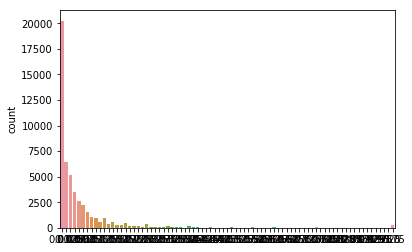

In [107]:
outcomes = RetainedJobs['RetainedJob'].values
sb.countplot(outcomes)

# FranchiseCode 

In [142]:
find_missing_zero(FranchiseCodes['FranchiseCode']) #no nan

[]
[0, 1, 32774, 7, 9, 10, 11, 32779, 32780, 14, 32783, 20, 32788, 23, 32791, 32792, 30, 33, 34, 32802, 32803, 32804, 32807, 40, 41, 32809, 43, 44, 45, 32811, 47, 32816, 50, 51, 32818, 53, 54, 32820, 57, 32825, 59, 60, 32826, 32828, 64, 32834, 67, 68, 32838, 74, 32845, 78, 82, 32850, 32851, 32852, 86, 32853, 32854, 32855, 32856, 32862, 97, 32868, 32870, 32871, 32872, 105, 106, 107, 32874, 32875, 32876, 32882, 32884, 119, 32889, 32890, 125, 32893, 32894, 32895, 130, 131, 32899, 32900, 135, 32903, 137, 138, 32905, 140, 141, 142, 32909, 32912, 32913, 146, 32915, 154, 155, 156, 32923, 158, 32927, 166, 32935, 32937, 171, 174, 176, 178, 180, 181, 182, 32949, 184, 32956, 32957, 190, 32958, 192, 32959, 32960, 195, 196, 32963, 32965, 199, 32966, 32967, 32972, 32973, 32974, 32975, 211, 214, 32984, 219, 32989, 224, 32994, 32995, 32996, 229, 33002, 235, 238, 33007, 240, 33008, 33009, 33012, 245, 248, 250, 252, 33023, 256, 258, 260, 33028, 262, 263, 264, 267, 268, 33035, 33037, 272, 274, 275, 280, 

([],
 [0,
  1,
  32774,
  7,
  9,
  10,
  11,
  32779,
  32780,
  14,
  32783,
  20,
  32788,
  23,
  32791,
  32792,
  30,
  33,
  34,
  32802,
  32803,
  32804,
  32807,
  40,
  41,
  32809,
  43,
  44,
  45,
  32811,
  47,
  32816,
  50,
  51,
  32818,
  53,
  54,
  32820,
  57,
  32825,
  59,
  60,
  32826,
  32828,
  64,
  32834,
  67,
  68,
  32838,
  74,
  32845,
  78,
  82,
  32850,
  32851,
  32852,
  86,
  32853,
  32854,
  32855,
  32856,
  32862,
  97,
  32868,
  32870,
  32871,
  32872,
  105,
  106,
  107,
  32874,
  32875,
  32876,
  32882,
  32884,
  119,
  32889,
  32890,
  125,
  32893,
  32894,
  32895,
  130,
  131,
  32899,
  32900,
  135,
  32903,
  137,
  138,
  32905,
  140,
  141,
  142,
  32909,
  32912,
  32913,
  146,
  32915,
  154,
  155,
  156,
  32923,
  158,
  32927,
  166,
  32935,
  32937,
  171,
  174,
  176,
  178,
  180,
  181,
  182,
  32949,
  184,
  32956,
  32957,
  190,
  32958,
  192,
  32959,
  32960,
  195,
  196,
  32963,
  32965,
  199,
 

In [141]:
FranchiseCodes = train_data[['Id','FranchiseCode']].copy()

In [126]:
FranchiseCodes_out = pd.merge(FranchiseCodes,ChargeOffs)

In [111]:
a = FranchiseCodes['FranchiseCode'].value_counts()
print(a)

1        31441
0        15834
78760      129
68020      108
50564       49
         ...  
70670        1
46330        1
44066        1
11250        1
34849        1
Name: FranchiseCode, Length: 849, dtype: int64


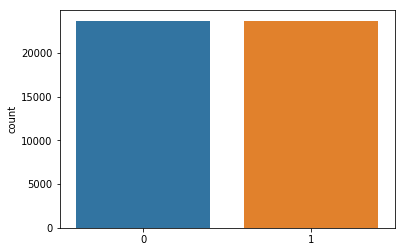

In [137]:
a_t = extractRows(FranchiseCodes_out,200,columns = ['FranchiseCode'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

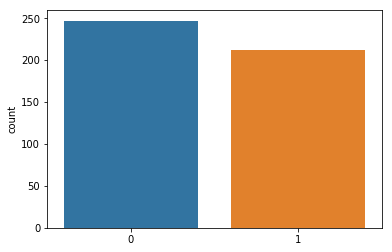

In [117]:
a_t = extractRows(FranchiseCodes_out,2,columns = ['FranchiseCode'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

In [145]:
FranchiseCodesIdx = FranchiseCodes['FranchiseCode'].unique()[2:]

In [147]:
np.save("FranchiseCodesIdx.npy",FranchiseCodesIdx)

In [149]:
def foo(x):
    if x in FranchiseCodesIdx:
        return list(FranchiseCodesIdx).index(x)+1
    else:
        return 0
FranchiseCodes['FranchiseCode'] = FranchiseCodes['FranchiseCode'].map(lambda x:foo(x))

In [150]:
a = FranchiseCodes['FranchiseCode'].value_counts()
print(a[a>30])

0      47275
12       129
11       108
53        49
28        45
18        43
59        40
34        36
138       31
Name: FranchiseCode, dtype: int64


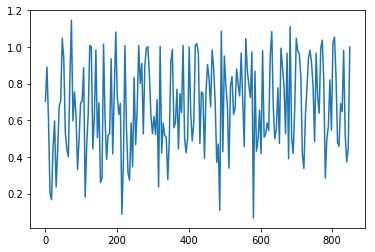

In [153]:
y1,y2 = plotPassRate(FranchiseCodes_out,850,200)

In [154]:
for i in range(0,20):
    print(y1[i]/y2[i])

0.7048942216608778
0.39580815469753833
0.375
1.0
1.0
0.6666666666666666
1.0
1.0
0.3333333333333333
0.8
0.1724137931034483
0.875
0.5596330275229358
0.16923076923076924
0.4
0.8333333333333334
0.3333333333333333
0.15384615384615385
0.5
0.7954545454545454


> Conclusion: I cannot find something special. So I turn them into continuous int and leave it for the model to find out which FranchiseCode is special. 

In [155]:
FranchiseCodes

Id  FranchiseCode
0          0              0
1          1              0
2          2              0
3          3              0
4          4              0
...      ...            ...
49995  49995              0
49996  49996              0
49997  49997              0
49998  49998              0
49999  49999              0

[50000 rows x 2 columns]

# UrbanRural

In [156]:
find_missing_zero(UrbanRurals['UrbanRural']) #no nan

[]
[32768, 3, 32773, 32775, 32777, 32782, 15, 16, 32783, 18, 32785, 24, 32793, 27, 32798, 31, 32, 32799, 32801, 32802, 36, 32804, 32806, 41, 32809, 32810, 45, 46, 32813, 32818, 32822, 56, 59, 61, 32829, 71, 32840, 75, 32844, 79, 80, 32847, 83, 84, 85, 88, 90, 93, 94, 95, 32861, 32863, 32865, 32866, 32867, 102, 32871, 32873, 110, 111, 32878, 32880, 114, 115, 117, 118, 32886, 32891, 124, 127, 32901, 32902, 135, 136, 32904, 32906, 32907, 140, 32909, 147, 148, 32916, 150, 32917, 32919, 161, 32931, 167, 32936, 171, 32940, 173, 32943, 32944, 177, 179, 181, 32950, 183, 32951, 32954, 188, 191, 194, 32964, 32965, 32966, 32967, 32969, 202, 203, 204, 32971, 206, 32973, 32975, 32977, 32980, 32982, 216, 32985, 222, 32990, 225, 227, 32996, 32997, 33000, 33003, 236, 33004, 33006, 243, 247, 33018, 253, 33022, 259, 33027, 33029, 33030, 33034, 269, 271, 33039, 273, 33042, 276, 277, 33044, 279, 33045, 33048, 33052, 287, 33056, 33057, 33058, 291, 33059, 295, 298, 299, 33068, 33069, 302, 303, 33073, 33074,

([],
 [32768,
  3,
  32773,
  32775,
  32777,
  32782,
  15,
  16,
  32783,
  18,
  32785,
  24,
  32793,
  27,
  32798,
  31,
  32,
  32799,
  32801,
  32802,
  36,
  32804,
  32806,
  41,
  32809,
  32810,
  45,
  46,
  32813,
  32818,
  32822,
  56,
  59,
  61,
  32829,
  71,
  32840,
  75,
  32844,
  79,
  80,
  32847,
  83,
  84,
  85,
  88,
  90,
  93,
  94,
  95,
  32861,
  32863,
  32865,
  32866,
  32867,
  102,
  32871,
  32873,
  110,
  111,
  32878,
  32880,
  114,
  115,
  117,
  118,
  32886,
  32891,
  124,
  127,
  32901,
  32902,
  135,
  136,
  32904,
  32906,
  32907,
  140,
  32909,
  147,
  148,
  32916,
  150,
  32917,
  32919,
  161,
  32931,
  167,
  32936,
  171,
  32940,
  173,
  32943,
  32944,
  177,
  179,
  181,
  32950,
  183,
  32951,
  32954,
  188,
  191,
  194,
  32964,
  32965,
  32966,
  32967,
  32969,
  202,
  203,
  204,
  32971,
  206,
  32973,
  32975,
  32977,
  32980,
  32982,
  216,
  32985,
  222,
  32990,
  225,
  227,
  32996,
  32997,
  

In [159]:
a = UrbanRurals['UrbanRural'].value_counts()
a

1    30059
0    13877
2     6064
Name: UrbanRural, dtype: int64

> Conclusion: Ideal format. Keep it.

# RevLineCr

In [177]:
RevLineCrs = train_data[['Id','RevLineCr']].copy()

In [163]:
a = RevLineCrs['RevLineCr'].value_counts()
a

N    21718
0    13466
Y    13289
T     1374
Name: RevLineCr, dtype: int64

In [164]:
RevLineCr_out = pd.merge(RevLineCrs,ChargeOffs)

In [160]:
find_missing_zero(RevLineCrs['RevLineCr']) #no nan

TypeError: must be real number, not str

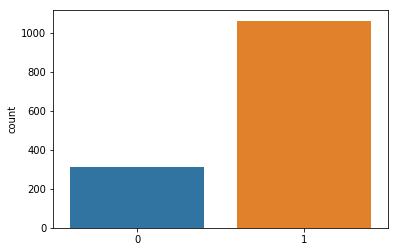

In [168]:
a_t = extractRows(RevLineCr_out,1400,columns = ['RevLineCr'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

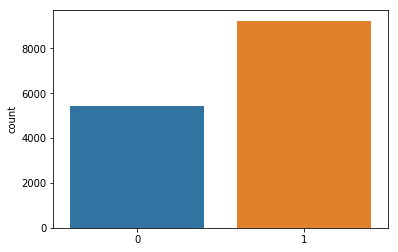

In [170]:
a_t = extractRows(RevLineCr_out,13444,columns = ['RevLineCr'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

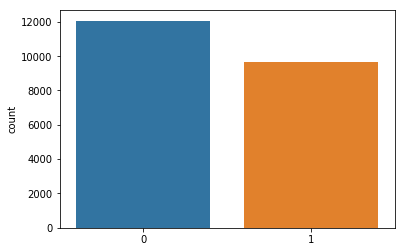

In [172]:
a_t = extractRows(RevLineCr_out,20000,columns = ['RevLineCr'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

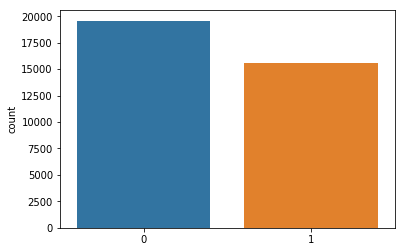

In [173]:
a_t = extractRows(RevLineCr_out,13444,columns = ['RevLineCr'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

> Conclusion: From the ChargeOff performance, we can guess that the 'T' is acutally 'Y', and the 0 is N.

> Process: Modify them into 1(yes) or 0(no)

In [178]:
def foo(x):
    if x=='T' or x=='Y':
        return 1
    else:
        return 0
RevLineCrs['RevLineCr'] = RevLineCrs['RevLineCr'].map(lambda x:foo(x))

In [180]:
RevLineCrs['RevLineCr'].value_counts()

0    35337
1    14663
Name: RevLineCr, dtype: int64

# LowDoc

In [185]:
LowDocs = train_data[['Id','LowDoc']].copy()
a = LowDocs['LowDoc'].value_counts()
a

N    44714
Y     4934
S       56
0       53
A       36
C       33
R        2
Name: LowDoc, dtype: int64

In [187]:
lowDocs_out = pd.merge(LowDocs,ChargeOffs)

180


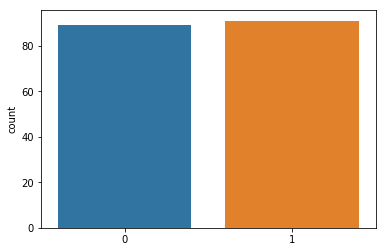

In [190]:
a_t = extractRows(lowDocs_out,60,columns = ['LowDoc'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

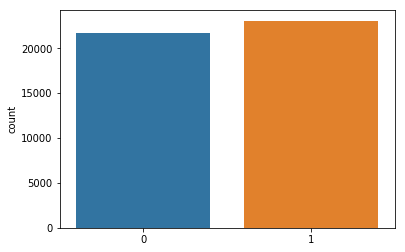

In [191]:
a_t = extractRows(lowDocs_out,40000,columns = ['LowDoc'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

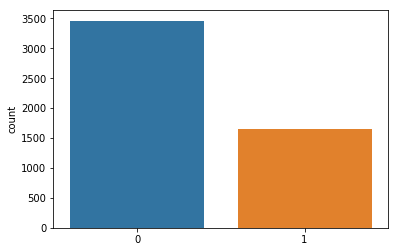

In [192]:
a_t = extractRows(lowDocs_out,40000,columns = ['LowDoc'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

> Conclusion: there is a bias for Yes and balanced for N and other strange letter. 

> Process: set 1 for Y and 0 for others

In [193]:
def foo(x):
    if x=='Y':
        return 1
    else:
        return 0
LowDocs['LowDoc'] = LowDocs['LowDoc'].map(lambda x:foo(x))

In [194]:
LowDocs['LowDoc'].value_counts()

0    45066
1     4934
Name: LowDoc, dtype: int64

# DisbursementDate

In [195]:
DisbursementDates_out = pd.merge(DisbursementDates,ChargeOffs)

In [338]:
a = DisbursementDates['DisbursementDate'].value_counts()
a #50,150,250,400,400+;5828,14976,24270,35227

30-Apr-07    591
31-Mar-07    563
31-Aug-07    560
30-Nov-06    558
31-Dec-06    554
            ... 
29-Dec-99      1
6-Feb-12       1
15-Dec-86      1
29-Oct-09      1
14-Dec-98      1
Name: DisbursementDate, Length: 2433, dtype: int64

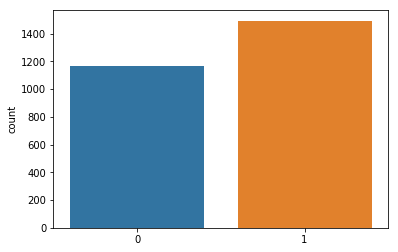

In [248]:
a_t = extractRows(DisbursementDates_out,5,columns = ['DisbursementDate'],larger=False) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

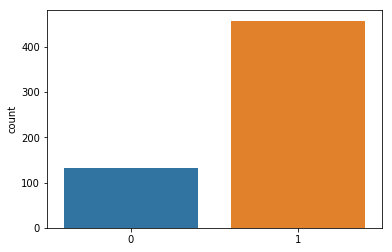

In [233]:
a_t = extractRows(DisbursementDates_out,563,columns = ['DisbursementDate'],larger=True) #0-5
outcomes = a_t['ChargeOff'].values
sb.countplot(outcomes)

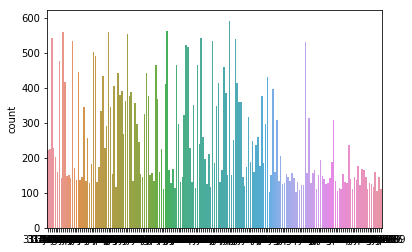

In [203]:
outcomes = a_t['DisbursementDate'].values
sb.countplot(outcomes)

> Conclusion: If we change the value_counts above, we can find that for a certain day, more frequently it appears, more possible ChargeOff to be 1.

> Process: We rank it by frequency, and give a value between 0-1. For missing value, I set the median(?)

In [350]:
DisbursementDates = train_data[['Id','DisbursementDate']].copy()

In [340]:
DisbursementDatesFreq = DisbursementDates['DisbursementDate'].value_counts().values

In [341]:
DisbursementDatesFreq = DisbursementDatesFreq/591.0

In [343]:
len(DisbursementDatesFreq)

2433

In [344]:
DisbursementDatesIdx = DisbursementDates['DisbursementDate'].value_counts().index

array(['30-Apr-07', '1.0'], dtype='<U20')

In [287]:
nan_l,_ = find_missing_zero(DisbursementDates['DisbursementDate'])

[22529, 19975, 31243, 40971, 46610, 32282, 47130, 14876, 33316, 15913, 24621, 7726, 33348, 1615, 49747, 22102, 24150, 27738, 6751, 4706, 14435, 16995, 24163, 34405, 4714, 18544, 33906, 9844, 45176, 23683, 648, 48264, 37004, 661, 19607, 7833, 25243, 45726, 48802, 163, 40103, 5296, 21685, 23741, 23231, 36544, 5313, 24275, 12503, 22743, 30424, 2267, 34524, 14560, 23777, 10465, 21218, 45283, 38629, 29929, 14062, 9457, 10993, 38642, 25335, 19196, 25349, 39180, 26401, 18724, 22820, 25894, 46891, 2861, 11057, 36151, 6468, 332, 27468, 848, 359, 40812, 26477, 38765, 25976, 47993, 49018, 46459, 20351, 25472, 1409, 4484, 2951, 9104, 17299, 23451, 27040, 49058, 49575, 40363, 22958, 23987, 14260, 8122, 30149, 3536, 24022, 30681, 12761, 475, 14303, 21985, 17895, 41453, 24050, 9715, 3575, 48121, 6138]
[]


In [351]:
np.save("DisbursementDatesIndex.npy",np.array(DisbursementDatesIdx))
np.save("DisbursementDatesFreq.npy",np.array(DisbursementDatesFreq))

In [352]:
def foo(x,np_index,values):
    avg = np.average(values)
    if not x == x:
        return avg
    return values[list(np_index).index(x)]
DisbursementDates['DisbursementDate'] = DisbursementDates['DisbursementDate'].map(lambda x:foo(x,DisbursementDatesIdx,DisbursementDatesFreq))

In [353]:
DisbursementDates['DisbursementDate'].value_counts()

0.001692    1485
0.786802     930
0.637902     754
0.243655     720
0.609137     720
            ... 
0.045685      27
0.043993      26
0.040609      24
0.033841      20
0.032149      19
Name: DisbursementDate, Length: 176, dtype: int64

In [354]:
# Save what is done until now...this script is too long.
a = pd.merge(NewExists,CreateJobs)
b = pd.merge(a,RetainedJobs)
c = pd.merge(b,FranchiseCodes)
d = pd.merge(c,UrbanRurals)
e = pd.merge(d,RevLineCrs)
f = pd.merge(e,LowDocs)
g = pd.merge(f,DisbursementDates)
g.to_csv("NewExists_to_DisbursementDates.csv",index=None,header=['Id','NewExist','CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural','RevLineCr','LowDoc','DisbursementDate'])